In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from datetime import datetime

sc = SparkSession.builder.getOrCreate()

In [2]:
# Read the data from the CSV file and return a spark dataframe
df = sc.read.csv("../data/exp3/new/ws_orderinfo_orders_server.csv", header=True, inferSchema=True)
# Drop the incomplete order
df = df.dropna()

In [3]:
def dateformat(s):
    return datetime.strptime(s, '%m/%d/%Y %H:%M:%S')

def timedelta(x, y):
    return (dateformat(x) - dateformat(y)).total_seconds()

# Preprocess the columns to get the time interval between shipping and receiving
data = df.select('shipdate', 'takendate', 'orderdate', 'red', 'blue', 'yellow', 'black', 'white').rdd.map(
    lambda x: Row(transitDuration=timedelta(x.shipdate, x.takendate),
                  fulfillDuration=timedelta(x.shipdate, x.orderdate),
                  amount=(x.red + x.blue + x.yellow + x.black + x.white))
)
data.take(5)

[Row(amount=18, fulfillDuration=107.0, transitDuration=88.0),
 Row(amount=26, fulfillDuration=215.0, transitDuration=207.0),
 Row(amount=12, fulfillDuration=223.0, transitDuration=91.0),
 Row(amount=13, fulfillDuration=274.0, transitDuration=153.0),
 Row(amount=24, fulfillDuration=348.0, transitDuration=194.0)]

In [4]:
# Convert the data format to ['features', 'label'] for training
train = data.map(lambda x: (Vectors.dense([x.amount]), x.transitDuration)).toDF(["features", "label"])
train.take(5)

[Row(features=DenseVector([18.0]), label=88.0),
 Row(features=DenseVector([26.0]), label=207.0),
 Row(features=DenseVector([12.0]), label=91.0),
 Row(features=DenseVector([13.0]), label=153.0),
 Row(features=DenseVector([24.0]), label=194.0)]

In [5]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
# trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [3.533245372520663]
Intercept: 109.665775049
numIterations: 3
objectiveHistory: [0.5, 0.4536182490790944, 0.3762147175565874]
RMSE: 45.666405
r2: 0.252371


In [6]:
X = train.rdd.map(lambda x: x.features[0]).collect()
y = train.rdd.map(lambda x: x.label).collect()

p = lrModel.transform(train).select('prediction').rdd.flatMap(list).collect()

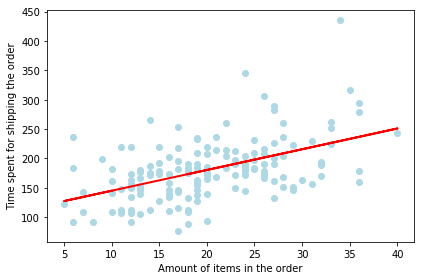

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel('Amount of items in the order')
plt.ylabel('Time spent for shipping the order')
plt.scatter(X, y, c='lightblue')
plt.plot(X, p, color='red', linewidth=2)
plt.tight_layout()
plt.show()